In [1]:
# Importing libraries
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
from collections import Counter
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import warnings
from scipy.stats import norm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## 1. Import Data

In [2]:
def scraper_basic_statistics(starting_year, ending_year):
    df = pd.DataFrame()
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Years", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the table on the page
                table = soup.find('table')

                # Read the df
                df_season = pd.read_html(str(table))[0]
                df_season = df_season.drop(columns=["Rk"])

                df_season['Season'] = year # add season
                df_season.drop_duplicates(keep = False, inplace = True) # delete headers repeated
                
                # add the id cause it has to be read from another place, it's not in the table
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                df_season['ID'] = ids
                
                # Eliminiamo le righe relative ai giocatori che hanno cambiato squadra nell'arco della stagione,
                # mantenendo solo la riga relativa alle statistiche delle 2 o più squadre in cui ha militato.
                condition = (df_season['Tm'] != 'TOT') & df_season.duplicated(subset=['Player', 'Season'], keep=False)

                # Applica le condizioni utilizzando il metodo loc
                df_season = df_season.loc[~condition]
                
                # concat
                df = pd.concat([df, df_season])
                time.sleep(1)
            
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
    
    columns_float = ['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
                    'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    
    df[columns_float] = df[columns_float].astype(float)
    
    columns_int = ['G', 'Age', 'GS']
    df[columns_int] = df[columns_int].astype(int)
    
    return df

In [3]:
def scraper_advanced_statistics(starting_year, ending_year):
    df = pd.DataFrame()
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Years", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the table on the page
                table = soup.find('table')

                # Read the df
                df_season = pd.read_html(str(table))[0]
                df_season = df_season.drop(columns=['Unnamed: 19', "Unnamed: 24", "Rk"])
                df_season['Season'] = year # add season
                df_season.drop_duplicates(keep = False, inplace = True) # delete headers repeated
                
                # add the id cause it has to be read from another place, it's not in the table
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                df_season['ID'] = ids
                
                # Eliminiamo le righe relative ai giocatori che hanno cambiato squadra nell'arco della stagione,
                # mantenendo solo la riga relativa alle statistiche delle 2 o più squadre in cui ha militato.
                condition = (df_season['Tm'] != 'TOT') & df_season.duplicated(subset=['Player', 'Season'], keep=False)

                # Applica le condizioni utilizzando il metodo loc
                df_season = df_season.loc[~condition]
                
                # concat
                df = pd.concat([df, df_season])
                time.sleep(1)
            
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
        
    columns_float = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
                    'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
    df[columns_float] = df[columns_float].astype(float)
    
    columns_int = ['G', 'Age', 'MP']
    df[columns_int] = df[columns_int].astype(int)

    return df

In [4]:
df_basic = scraper_basic_statistics(2010, 2023)
df_basic.info()

Processing Years: 100%|██████████| 14/14 [00:46<00:00,  3.33s/year]

<class 'pandas.core.frame.DataFrame'>
Index: 7056 entries, 0 to 704
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7056 non-null   object 
 1   Pos     7056 non-null   object 
 2   Age     7056 non-null   int32  
 3   Tm      7056 non-null   object 
 4   G       7056 non-null   int32  
 5   GS      7056 non-null   int32  
 6   MP      7056 non-null   float64
 7   FG      7056 non-null   float64
 8   FGA     7056 non-null   float64
 9   FG%     7022 non-null   float64
 10  3P      7056 non-null   float64
 11  3PA     7056 non-null   float64
 12  3P%     6378 non-null   float64
 13  2P      7056 non-null   float64
 14  2PA     7056 non-null   float64
 15  2P%     6984 non-null   float64
 16  eFG%    7022 non-null   float64
 17  FT      7056 non-null   float64
 18  FTA     7056 non-null   float64
 19  FT%     6746 non-null   float64
 20  ORB     7056 non-null   float64
 21  DRB     7056 non-null   float64
 22  TRB   

In [5]:
df_basic.tail(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID
682,Jeenathan Williams,SG,23,POR,5,4,25.4,4.8,7.8,0.615,0.6,1.6,0.375,4.2,6.2,0.677,0.654,0.4,0.6,0.667,2.0,1.0,3.0,2.0,0.6,0.4,0.8,2.6,10.6,2023,willije02
684,Kenrich Williams,PF,28,OKC,53,10,22.8,3.4,6.5,0.517,0.9,2.5,0.373,2.4,4.0,0.608,0.590,0.3,0.7,0.436,1.8,3.1,4.9,2.0,0.8,0.3,0.6,2.1,8.0,2023,willike04
685,Mark Williams,C,21,CHO,43,17,19.3,3.7,5.8,0.637,0.0,0.0,NaN,3.7,5.8,0.637,0.637,1.6,2.3,0.691,2.2,4.9,7.1,0.4,0.7,1.0,0.9,2.2,9.0,2023,willima07
686,Patrick Williams,PF,21,CHI,82,65,28.3,3.8,8.3,0.464,1.4,3.4,0.415,2.4,4.9,0.498,0.549,1.1,1.3,0.857,1.0,3.0,4.0,1.2,0.9,0.9,1.2,1.8,10.2,2023,willipa01
687,Robert Williams,C,25,BOS,35,20,23.5,3.6,4.9,0.747,0.0,0.0,0.000,3.6,4.8,0.751,0.747,0.7,1.2,0.610,3.0,5.4,8.3,1.4,0.6,1.4,1.0,1.9,8.0,2023,williro04
688,Vince Williams Jr.,SG,22,MEM,15,1,7.0,0.8,2.7,0.300,0.3,1.9,0.143,0.5,0.8,0.667,0.350,0.1,0.1,1.000,0.3,0.7,1.0,0.3,0.4,0.1,0.3,0.8,2.0,2023,willivi01
689,Ziaire Williams,SF,21,MEM,37,4,15.2,2.3,5.3,0.429,0.7,2.6,0.258,1.6,2.7,0.596,0.492,0.5,0.6,0.773,0.4,1.7,2.1,0.9,0.4,0.2,1.0,1.6,5.7,2023,willizi02
690,Zion Williamson,PF,22,NOP,29,29,33.0,9.8,16.2,0.608,0.2,0.7,0.368,9.6,15.5,0.618,0.615,6.1,8.6,0.714,2.0,5.0,7.0,4.6,1.1,0.6,3.4,2.2,26.0,2023,willizi01
691,Dylan Windler,SF,26,CLE,3,0,3.3,0.7,1.0,0.667,0.3,0.7,0.500,0.3,0.3,1.000,0.833,0.0,0.0,NaN,0.0,0.0,0.0,0.3,0.3,0.0,0.3,0.0,1.7,2023,windldy01
692,Justise Winslow,PF,26,POR,29,11,26.8,2.8,6.8,0.409,0.5,1.6,0.311,2.3,5.3,0.438,0.444,0.7,1.0,0.714,1.7,3.3,5.0,3.4,1.0,0.4,1.5,3.1,6.8,2023,winslju01


In [6]:
starting_year = 2010
ending_year = 2023

df_advanced = scraper_advanced_statistics(starting_year=starting_year, ending_year=ending_year)
df_advanced.info()

Processing Years: 100%|██████████| 14/14 [00:47<00:00,  3.38s/year]

<class 'pandas.core.frame.DataFrame'>
Index: 7056 entries, 0 to 704
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7056 non-null   object 
 1   Pos     7056 non-null   object 
 2   Age     7056 non-null   int32  
 3   Tm      7056 non-null   object 
 4   G       7056 non-null   int32  
 5   MP      7056 non-null   int32  
 6   PER     7054 non-null   float64
 7   TS%     7023 non-null   float64
 8   3PAr    7022 non-null   float64
 9   FTr     7022 non-null   float64
 10  ORB%    7054 non-null   float64
 11  DRB%    7054 non-null   float64
 12  TRB%    7054 non-null   float64
 13  AST%    7054 non-null   float64
 14  STL%    7054 non-null   float64
 15  BLK%    7054 non-null   float64
 16  TOV%    7027 non-null   float64
 17  USG%    7054 non-null   float64
 18  OWS     7056 non-null   float64
 19  DWS     7056 non-null   float64
 20  WS      7056 non-null   float64
 21  WS/48   7054 non-null   float64
 22  OBPM  

In [7]:
df_advanced[df_advanced['Player'] == "LeBron James"].tail(50)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,ID
296,LeBron James,SF,25,CLE,76,2966,31.1,0.604,0.253,0.506,3.0,18.5,11.1,41.8,2.2,2.0,12.3,33.5,13.3,5.2,18.5,0.299,9.1,2.8,11.8,10.3,2010,jamesle01
322,LeBron James,SF,26,MIA,79,3063,27.3,0.594,0.188,0.446,3.3,18.7,11.4,34.9,2.1,1.3,13.8,31.5,10.3,5.3,15.6,0.244,6.3,1.8,8.1,7.8,2011,jamesle01
280,LeBron James,SF,27,MIA,62,2326,30.7,0.605,0.127,0.429,5.0,19.7,12.6,33.6,2.6,1.7,13.3,32.0,10.0,4.5,14.5,0.298,8.2,2.7,10.9,7.6,2012,jamesle01
265,LeBron James,PF,28,MIA,76,2877,31.6,0.640,0.188,0.395,4.4,20.8,13.1,36.4,2.4,1.9,12.4,30.2,14.6,4.7,19.3,0.322,9.3,2.4,11.7,9.9,2013,jamesle01
307,LeBron James,PF,29,MIA,77,2902,29.3,0.649,0.226,0.432,3.6,18.9,11.5,32.0,2.2,0.8,14.4,31.0,12.3,3.7,15.9,0.264,7.8,1.1,8.8,7.9,2014,jamesle01
303,LeBron James,SF,30,CLE,69,2493,25.9,0.577,0.265,0.413,2.4,16.6,9.6,38.6,2.3,1.6,15.3,32.3,7.4,2.9,10.4,0.199,6.1,1.0,7.1,5.7,2015,jamesle01
276,LeBron James,SF,31,CLE,76,2709,27.5,0.588,0.199,0.347,4.7,18.8,11.8,36.0,2.0,1.5,13.2,31.4,9.6,4.0,13.6,0.242,7.0,2.0,9.0,7.5,2016,jamesle01
281,LeBron James,SF,32,CLE,74,2794,27.0,0.619,0.254,0.395,4.0,20.7,12.6,41.3,1.6,1.3,16.1,30.0,9.8,3.0,12.9,0.221,6.4,1.2,7.6,6.7,2017,jamesle01
316,LeBron James,PF,33,CLE,82,3026,28.6,0.621,0.257,0.336,3.7,22.3,13.1,44.4,1.9,2.0,16.1,31.6,11.0,3.0,14.0,0.221,7.3,1.4,8.7,8.2,2018,jamesle01
347,LeBron James,SF,34,LAL,55,1937,25.6,0.588,0.299,0.382,3.1,21.3,12.4,39.4,1.7,1.4,13.3,31.6,4.7,2.6,7.2,0.179,6.4,1.7,8.0,4.9,2019,jamesle01


In [8]:
print(df_basic.shape)
print(df_advanced.shape)

(7056, 31)
(7056, 28)


In [9]:
merged_df = pd.merge(df_basic, df_advanced[['PER', 'ID', 'Season', 'Player', 'WS', 'WS/48']], on=['ID', 'Season', 'Player'])
merged_df.sort_values(by=['ID', 'Season']).head(30)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053
5372,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,3.7,0.546,0.544,0.9,1.8,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,2021,achiupr01,14.2,1.3,0.085
5912,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2022,achiupr01,12.7,2.5,0.070
6517,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,3.0,5.4,0.564,0.521,1.6,2.3,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2,2023,achiupr01,15.2,2.2,0.093
1372,Quincy Acy,PF,22,TOR,29,0,11.8,1.4,2.6,0.560,0.0,0.1,0.500,1.4,2.5,0.562,0.567,1.1,1.3,0.816,1.0,1.6,2.7,0.4,0.4,0.5,0.6,1.8,4.0,2013,acyqu01,15.9,1.1,0.157
1839,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,0.468,0.1,0.2,0.267,1.0,2.0,0.492,0.482,0.6,0.8,0.660,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,2014,acyqu01,10.1,1.5,0.086
2319,Quincy Acy,PF,24,NYK,68,22,18.9,2.2,4.9,0.459,0.3,0.9,0.300,2.0,4.0,0.494,0.486,1.1,1.4,0.784,1.2,3.3,4.4,1.0,0.4,0.3,0.9,2.2,5.9,2015,acyqu01,11.9,1.7,0.063
2811,Quincy Acy,PF,25,SAC,59,29,14.8,2.0,3.6,0.556,0.3,0.8,0.388,1.7,2.8,0.606,0.600,0.8,1.2,0.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016,acyqu01,14.7,2.5,0.137


In [10]:
def rookies_id(starting_year, ending_year):
    rookies_per_year = {}
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Rookies", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_rookies.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')
                    
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                
                rookies_per_year[year] = ids
                time.sleep(1)
                
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
            
    return rookies_per_year

In [11]:
rookies_id = rookies_id(starting_year=starting_year, ending_year=ending_year)

Processing Rookies: 100%|██████████| 14/14 [00:19<00:00,  1.36s/year]


Adding PER_mean columns which represents the value of PER of the entire career of a certain player in NBA.

In [12]:
merged_df['PER'] = merged_df['PER'].astype(float)

In [13]:
merged_df[merged_df['ID'] == "abrinal01"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053


In [14]:
mean_PER = merged_df.groupby('ID')['PER'].mean().round(2)
merged_df = pd.merge(merged_df, mean_PER, on='ID', how='left', suffixes=('', '_mean'))
merged_df[merged_df['ID'] == "abrinal01"].head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096,8.47
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094,8.47
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053,8.47


Selecting only the rows relative to rookie's year for each player.

In [15]:
rookies_id

def inverted_rookies(dic):
    inverted_rookies = {}
    for key in dic.keys():
        for id in dic[key]:
            inverted_rookies[id] = key
    return inverted_rookies

In [16]:
inv_rookies = inverted_rookies(rookies_id)
inv_rookies = pd.DataFrame(list(inv_rookies.items()), columns=['ID', 'Season'])
inv_rookies.head(10)

,ID,Season
0,anderda03,2010
1,anderan02,2010
2,pendeje02,2010
3,beaubro01,2010
4,blairde01,2010
5,brockjo01,2010
6,brownde04,2010
7,budinch01,2010
8,carrode01,2010
9,casspom01,2010


In [17]:
rookies_df = pd.merge(merged_df, inv_rookies, on=['ID', 'Season'])
rookies_df.head(30)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.50
1,Antonio Anderson,SF,24,OKC,1,0,15.0,1.0,3.0,0.333,0.0,0.0,NaN,1.0,3.0,0.333,0.333,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2010,anderan02,-1.7,0.0,-0.104,-1.70
2,Jeff Ayres,C,22,POR,39,4,10.4,1.1,1.7,0.662,0.0,0.0,NaN,1.1,1.7,0.662,0.662,0.5,0.5,0.900,0.6,1.9,2.5,0.0,0.2,0.4,0.3,1.9,2.7,2010,pendeje02,12.1,1.3,0.156,12.30
3,Rodrigue Beaubois,PG,21,DAL,56,16,12.5,2.8,5.3,0.518,0.8,2.0,0.409,2.0,3.4,0.582,0.594,0.8,0.9,0.808,0.2,1.2,1.4,1.3,0.5,0.2,1.0,1.5,7.1,2010,beaubro01,18.5,2.0,0.134,13.95
4,DeJuan Blair,PF,20,SAS,82,23,18.2,3.4,6.0,0.556,0.0,0.0,0.000,3.4,6.0,0.558,0.556,1.1,2.0,0.547,2.4,4.0,6.4,0.8,0.6,0.5,1.4,2.7,7.8,2010,blairde01,17.7,4.6,0.147,13.91
5,Jon Brockman,PF,22,SAC,52,4,12.6,1.1,2.0,0.534,0.0,0.0,NaN,1.1,2.0,0.534,0.534,0.7,1.2,0.597,2.0,2.1,4.1,0.4,0.3,0.1,0.4,2.2,2.8,2010,brockjo01,12.4,1.7,0.125,9.53
6,Derrick Brown,SF,22,CHA,57,0,9.4,1.2,2.6,0.463,0.0,0.1,0.286,1.2,2.5,0.471,0.469,0.8,1.3,0.667,0.5,0.8,1.4,0.3,0.4,0.2,0.3,0.9,3.3,2010,brownde04,12.6,1.3,0.114,13.40
7,Chase Budinger,SF,21,HOU,74,4,20.1,3.4,7.6,0.441,1.2,3.4,0.369,2.1,4.3,0.497,0.522,0.9,1.2,0.770,0.5,2.5,3.0,1.2,0.5,0.1,0.6,1.1,8.9,2010,budinch01,14.1,3.1,0.100,12.63
8,DeMarre Carroll,SF,23,MEM,71,1,11.2,1.2,3.1,0.396,0.0,0.1,0.000,1.2,3.0,0.407,0.396,0.5,0.7,0.623,0.7,1.4,2.1,0.5,0.4,0.1,0.3,1.5,2.9,2010,carrode01,8.5,0.5,0.031,12.08
9,Omri Casspi,SF,21,SAC,77,31,25.1,3.9,8.7,0.446,1.0,2.6,0.369,2.9,6.1,0.480,0.502,1.5,2.3,0.672,1.0,3.6,4.5,1.2,0.7,0.2,1.3,1.6,10.3,2010,casspom01,13.0,2.5,0.063,13.12


## 2. Data Cleaning

Cleaning positions, considering only the most important of them.

In [18]:
Counter(rookies_df['Pos'].tolist())

Counter({'SG': 336,
         'PG': 249,
         'PF': 245,
         'SF': 231,
         'C': 183,
         'SG-SF': 2,
         'PF-SF': 1,
         'C-PF': 1,
         'SF-SG': 1,
         'SG-PG': 1})

In [19]:
rookies_df['Pos'].replace('SG-SF', 'SG', inplace=True)
rookies_df['Pos'].replace('SF-SG', 'SF', inplace=True)
rookies_df['Pos'].replace('SG-PG', 'SG', inplace=True)
rookies_df['Pos'].replace('PF-SF', 'PF', inplace=True)
rookies_df['Pos'].replace('C-PF', 'C', inplace=True)
Counter(rookies_df['Pos'].tolist())

Counter({'SG': 339, 'PG': 249, 'PF': 246, 'SF': 232, 'C': 184})

## 3. Data Analysis

### 3.1 Correlation Matrix

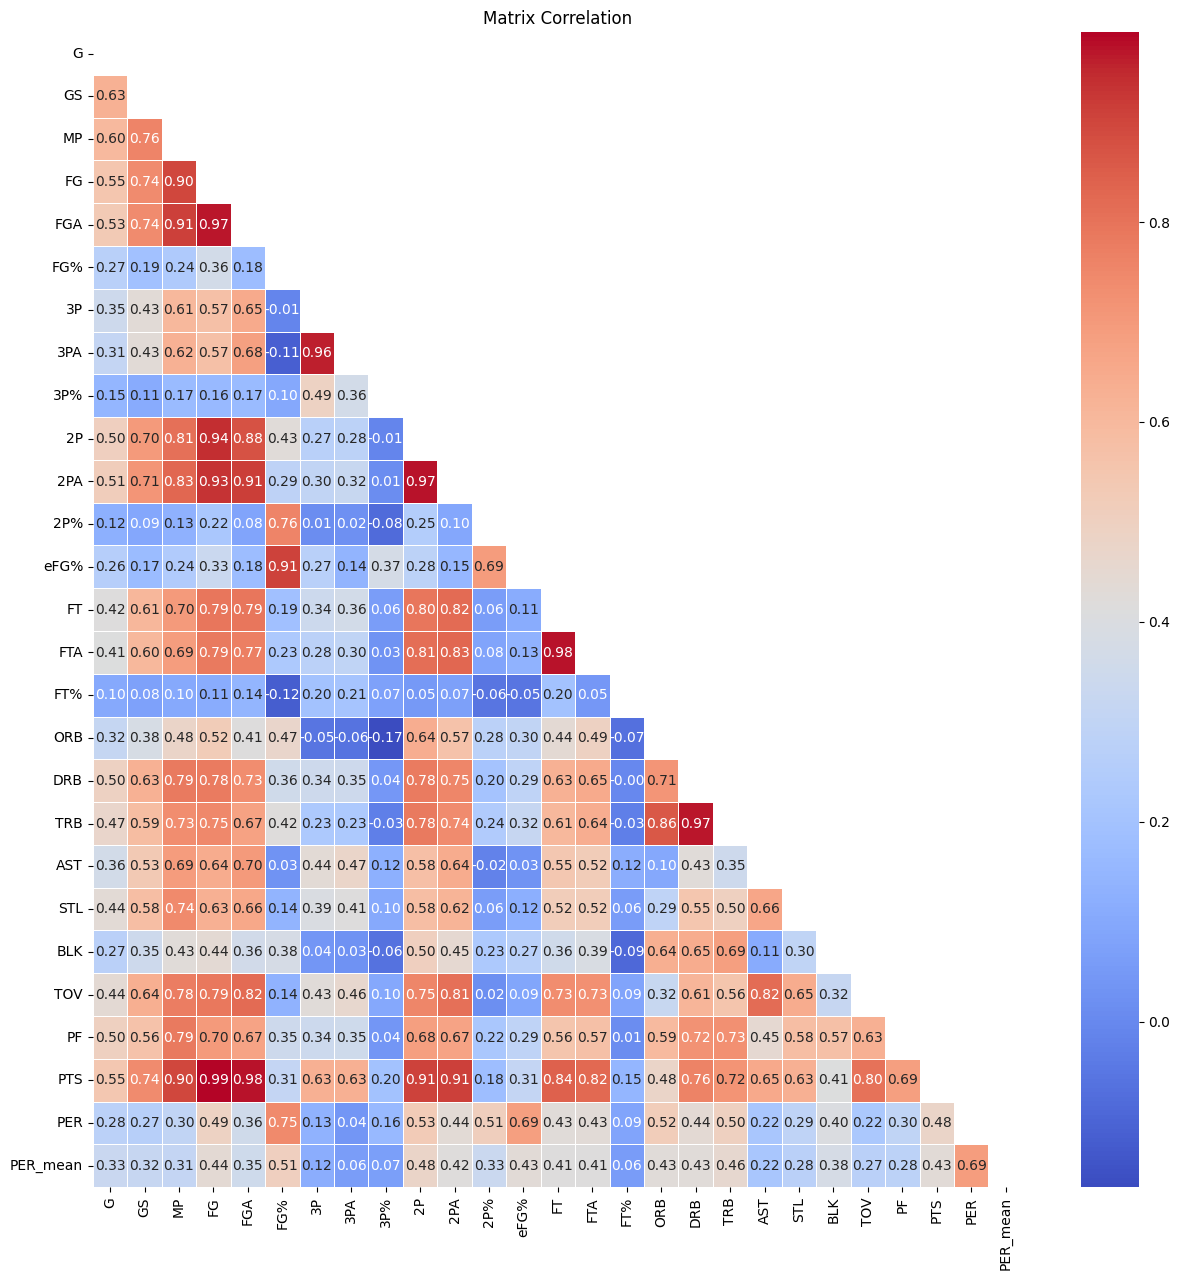

In [20]:
# CORRELATION MATRIX OF FIRST YEAR
columns_of_interest = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                        'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'PER_mean']

subset_df = rookies_df.dropna()[columns_of_interest]

# Calcolo della matrice di correlazione
correlation_matrix = subset_df.corr()

# Creazione di una matrice con la stessa forma di quella di correlazione ma con valori NaN
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creazione di un heatmap per visualizzare solo la metà superiore della matrice di correlazione
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title("Matrix Correlation")
plt.show()

## 4. Regression

* FRANCESCO SCEGLI TRAINING SET E TEST SET COME VUOI TE 
* FORSE DOVREMMO FILTRARE GLI OUTLIERS? TOGLIERE CHI NON HA GIOCATO UN TOT DI PARTITE?

In [21]:
print(rookies_df.shape)
rookies_df=rookies_df.dropna()
rookies_df.dropna().shape


(1250, 35)


(990, 35)

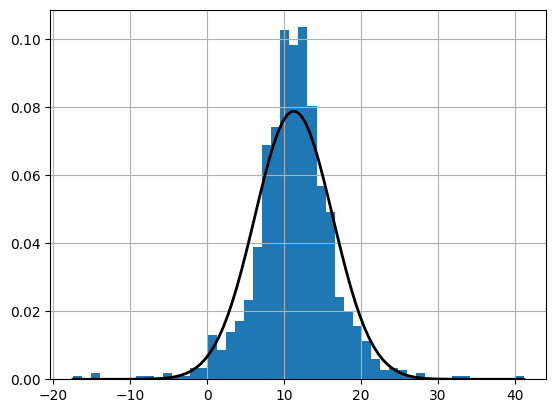

In [23]:
rookies_df_2023=rookies_df[rookies_df["Season"]==2023]
Y=rookies_df["PER_mean"]
Y.hist(bins=50, density = True)

mu, std = Y.mean(), Y.std()

# Creare un array di valori x per la curva gaussiana
x = np.linspace(Y.min(), Y.max(), 100)
p = norm.pdf(x, mu, std)

# Disegnare la curva gaussiana
plt.plot(x, p, 'k', linewidth=2)
plt.show()


* The distribution of PER_mean for all the past players from 2012 to 2022 looks like a Gaussian distribution

In [24]:
rookies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 0 to 1249
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    990 non-null    object 
 1   Pos       990 non-null    object 
 2   Age       990 non-null    int32  
 3   Tm        990 non-null    object 
 4   G         990 non-null    int32  
 5   GS        990 non-null    int32  
 6   MP        990 non-null    float64
 7   FG        990 non-null    float64
 8   FGA       990 non-null    float64
 9   FG%       990 non-null    float64
 10  3P        990 non-null    float64
 11  3PA       990 non-null    float64
 12  3P%       990 non-null    float64
 13  2P        990 non-null    float64
 14  2PA       990 non-null    float64
 15  2P%       990 non-null    float64
 16  eFG%      990 non-null    float64
 17  FT        990 non-null    float64
 18  FTA       990 non-null    float64
 19  FT%       990 non-null    float64
 20  ORB       990 non-null    float64
 2

In [25]:
X_rook=rookies_df.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])
X_rook=sm.add_constant(X_rook)
X_rook=X_rook.reset_index(drop=True)
Y=Y.reset_index(drop=True)

In [26]:
len(Y),len(X_rook)

(990, 990)

In [27]:
reg=sm.OLS(Y,X_rook).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     39.18
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          4.81e-138
Time:                        15:28:06   Log-Likelihood:                -2631.6
No. Observations:                 990   AIC:                             5321.
Df Residuals:                     961   BIC:                             5463.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5048      1.984      5.799      0.0

<Axes: ylabel='PER_mean'>

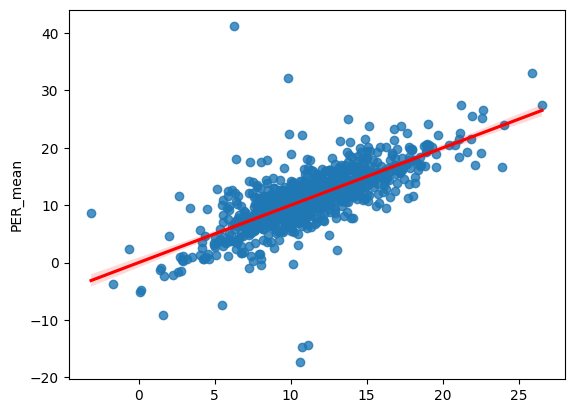

In [28]:
sns.regplot(x=reg.predict(X_rook), y=Y,line_kws={'color': 'red'})

* Out model predicts well the average players, but underestimates the elitè rookies and overestimates the worst

In [29]:
X_rook_2023=rookies_df_2023.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])
X_rook_2023=sm.add_constant(X_rook_2023)
X_rook_2023=X_rook_2023.reset_index(drop=True)

# We create the data matrix for the 2023 rookies

In [30]:
pred=reg.predict(X_rook_2023)
pred

0     10.139057
1     11.080472
2     18.168453
3     13.061883
4      9.435195
5      2.838169
6      7.273219
7     11.395209
8     11.263571
9     10.261399
10     7.639789
11    14.226595
12    12.342994
13    12.077522
14     8.582910
15    12.263579
16    10.990781
17     8.556193
18    10.976158
19    15.033112
20    13.710471
21    11.108835
22    18.301650
23    15.293171
24    10.975476
25     7.958684
26    15.493242
27    10.011597
28    13.092706
29     7.343195
30    14.267608
31    13.132812
32     8.786770
33     7.594746
34     5.389972
35    14.515141
36    11.223957
37    11.420870
38     7.772591
39    21.877167
40    12.640762
41     7.696237
42    11.587459
43    17.790788
44     8.622461
45    15.471301
46     9.549122
47     6.549077
48    16.544882
49    12.996013
50    10.829180
51    13.768006
52    10.929083
53     9.992315
54    10.430540
55     7.668799
56     6.897645
57    13.458728
58    10.493316
59     2.802122
60    12.922994
61    10.090580
62    14

In [31]:
rookies_df_2023["PER_pred"]=pred.values.round(2)
rookies_df_2023.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean,PER_pred
1165,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,1.4,2.7,0.532,0.532,0.9,1.2,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,2023,agbajoc01,9.5,1.3,0.053,9.5,10.14
1166,Patrick Baldwin Jr.,SF,20,GSW,31,0,7.3,1.4,3.5,0.394,1.0,2.7,0.381,0.4,0.8,0.440,0.541,0.1,0.2,0.667,0.0,1.3,1.3,0.4,0.2,0.1,0.4,0.5,3.9,2023,baldwpa01,11.3,0.1,0.029,11.3,11.08
1167,Paolo Banchero,PF,20,ORL,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,2023,banchpa01,14.9,2.4,0.047,14.9,18.17
1168,Dominick Barlow,PF,19,SAS,28,0,14.6,1.6,3.1,0.535,0.0,0.1,0.000,1.6,2.9,0.561,0.535,0.6,0.9,0.720,1.6,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,2023,barlodo01,12.4,0.7,0.082,12.4,13.06
1169,MarJon Beauchamp,SF,22,MIL,52,11,13.5,1.8,4.7,0.395,0.9,2.7,0.331,0.9,1.9,0.485,0.492,0.5,0.7,0.730,0.7,1.5,2.2,0.7,0.4,0.1,0.9,1.4,5.1,2023,beaucma01,8.2,0.4,0.027,8.2,9.44
1170,Buddy Boeheim,SF,23,DET,10,0,9.0,0.5,2.7,0.185,0.4,2.5,0.160,0.1,0.2,0.500,0.259,0.2,0.2,1.000,0.2,0.4,0.6,0.4,0.2,0.0,0.0,0.6,1.6,2023,boehebu01,0.5,-0.2,-0.091,0.5,2.84
1171,Jamaree Bouyea,PG,23,TOT,5,0,14.2,1.2,2.8,0.429,0.4,1.2,0.333,0.8,1.6,0.500,0.500,0.2,0.4,0.500,0.2,1.0,1.2,0.8,0.8,0.4,0.8,1.2,3.0,2023,bouyeja01,6.5,0.0,0.013,6.5,7.27
1172,Malaki Branham,SG,19,SAS,66,32,23.5,4.1,9.3,0.440,1.2,3.9,0.302,2.9,5.4,0.539,0.503,0.9,1.1,0.829,0.4,2.3,2.7,1.9,0.5,0.1,1.2,1.7,10.2,2023,branhma01,9.5,-0.1,-0.004,9.5,11.40
1173,Christian Braun,SG,21,DEN,76,6,15.5,1.9,3.8,0.495,0.4,1.3,0.354,1.4,2.5,0.565,0.554,0.5,0.8,0.625,0.6,1.8,2.4,0.8,0.5,0.2,0.5,1.3,4.7,2023,braunch01,10.3,1.9,0.079,10.3,11.26
1174,Kendall Brown,SG,19,IND,6,0,6.7,0.7,1.2,0.571,0.0,0.2,0.000,0.7,1.0,0.667,0.571,0.2,0.3,0.500,0.3,0.7,1.0,0.5,0.7,0.0,0.3,1.5,1.5,2023,brownke03,9.1,0.1,0.071,9.1,10.26
